In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout
from keras.callbacks import EarlyStopping

In [3]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_excel('btc_processed_data.xlsx')
df1=df.reset_index()['Close']

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,3853.757080,3907.795410,3851.692383,3859.583740,3859.583740,7661247975
1,2019-03-02,3855.318115,3874.607422,3832.127930,3864.415039,3864.415039,7578786076
2,2019-03-03,3862.266113,3875.483643,3836.905762,3847.175781,3847.175781,7253558152
3,2019-03-04,3845.091553,3867.381836,3733.749756,3761.557129,3761.557129,9029175788
4,2019-03-05,3759.832520,3903.916748,3745.183105,3896.375000,3896.375000,10174126415
...,...,...,...,...,...,...,...
1914,2024-05-27,68512.179688,70597.882812,68232.500000,69394.554688,69394.554688,25870990717
1915,2024-05-28,69392.195312,69514.640625,67227.156250,68296.218750,68296.218750,32722265965
1916,2024-05-29,68296.351562,68852.460938,67101.492188,67578.093750,67578.093750,26707072906
1917,2024-05-30,67576.085938,69500.539062,67118.078125,68364.992188,68364.992188,29509712534


In [6]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]
len(df1)

1919

In [7]:
test_size,train_size

(576, 1343)

In [8]:
import numpy as np

# Initiation value of lag
lag = 100

# Sliding windows function
def create_sliding_windows(data, lag):
    x = []
    y = []
    for i in range(len(data) - lag):
        x.append(data[i:i+lag])
        y.append(data[i+lag])  # Append the value at index i+lag as the label y
    return np.array(x), np.array(y)

# # Example usage with training and test data
# train_data = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])  # Example training data
# test_data = np.array([100, 110, 120, 130, 140])  # Example test data
combined_data = np.concatenate((train_data[-lag:], test_data))

# Create sliding windows for training data
x_train, y_train = create_sliding_windows(train_data, lag)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Create sliding windows for test data
x_test, y_test = create_sliding_windows(combined_data, lag)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Print the shapes to verify
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


x_train shape: (1243, 100, 1)
y_train shape: (1243, 1)
x_test shape: (576, 100, 1)
y_test shape: (576, 1)


In [9]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(lag, 1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100, 50)           2600      
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100, 50)           5050      
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [10]:
len(x_train), len(y_train),len(x_test), len(y_test)

(1243, 1243, 576, 576)

In [11]:
# # 9. Fit mô hình với dữ liệu train
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
20/20 [==============================] - 12s 270ms/step - loss: 0.3049 - val_loss: 0.0270
Epoch 2/100
20/20 [==============================] - 7s 356ms/step - loss: 0.1658 - val_loss: 0.0093
Epoch 3/100
20/20 [==============================] - 5s 253ms/step - loss: 0.0981 - val_loss: 0.0030
Epoch 4/100
20/20 [==============================] - 6s 306ms/step - loss: 0.0734 - val_loss: 0.0102
Epoch 5/100
20/20 [==============================] - 5s 256ms/step - loss: 0.0486 - val_loss: 0.0020
Epoch 6/100
20/20 [==============================] - 6s 316ms/step - loss: 0.0414 - val_loss: 0.0022
Epoch 7/100
20/20 [==============================] - 7s 325ms/step - loss: 0.0320 - val_loss: 0.0024
Epoch 8/100
20/20 [==============================] - 5s 251ms/step - loss: 0.0279 - val_loss: 0.0013
Epoch 9/100
20/20 [==============================] - 7s 341ms/step - loss: 0.0226 - val_loss: 0.0037
Epoch 10/100
20/20 [==============================] - 5s 247ms/step - loss: 0.0202 - val_l

In [12]:
x_test.shape

(576, 100, 1)

In [13]:
y_train.shape

(1243, 1)

In [14]:
len(x_test)

576

In [15]:
# 10. Dự báo dữ liệu test, val
y_pred_test = model.predict(x_test)
# Invert normalization min-max
y_pred_invert_norm = scaler.inverse_transform(y_pred_test)


18/18 [==============================] - 1s 48ms/step


In [16]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
# train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred_test)


In [17]:
len(y_pred_test)

576

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
y_pred_test_unscaled = scaler.inverse_transform(y_pred_test.reshape(-1, 1))
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
test_rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_test_unscaled))

# Calculate MAE
test_mae = mean_absolute_error(y_test_unscaled, y_pred_test_unscaled)

# Calculate MAPE
test_mape = np.mean(np.abs((y_test_unscaled - y_pred_test_unscaled) / y_test_unscaled)) * 100
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Testing MAE: 1141.203230116102
Testing RMSE: 1865.590080143547
Testing MAPE: 2.764262456366221


In [19]:
# 13.Predict cho 30, 60, 90 ngày sau
def predict_days(model, start_input, n_steps, predict_days):
    temp_input = list(start_input)
    temp_input = temp_input[0].tolist()

    lst_output = []
    i = 0
    while i < predict_days:
        if len(temp_input) > n_steps:
            x_input = np.array(temp_input[-n_steps:])
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1

    return lst_output


In [20]:
n_steps = 100

# Get the last 100 data points from the test data
x_input = test_data[-100:].reshape(1, -1)

# Predict 30, 60, and 90 days ahead
output_30_days = predict_days(model, x_input, n_steps, 30)
output_60_days = predict_days(model, x_input, n_steps, 60)
output_90_days = predict_days(model, x_input, n_steps, 90)

output_30_days = np.array(output_30_days).reshape(-1, 1)
output_60_days = np.array(output_60_days).reshape(-1, 1)
output_90_days = np.array(output_90_days).reshape(-1, 1)

output_30_days = scaler.inverse_transform(output_30_days)
output_60_days = scaler.inverse_transform(output_60_days)
output_90_days = scaler.inverse_transform(output_90_days)

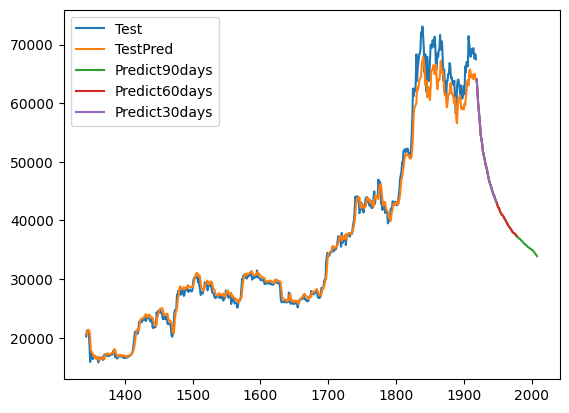

In [21]:
# 14. Vẽ hình
# train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
# plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')
plt.plot(test_data_index, y_pred, label='TestPred')

predict_30_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
predict_60_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 60, step=1)
predict_90_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 90, step=1)

plt.plot(predict_90_days_index, output_90_days, label='Predict90days')
plt.plot(predict_60_days_index, output_60_days, label='Predict60days')
plt.plot(predict_30_days_index, output_30_days, label='Predict30days')

plt.legend()
plt.show()